# **EECS 4214 Final Project**



## Section 1

---



### **What is the existing state-of-the-art?**

When we examine the current 5th-gen cellular networks, there are some key aspects that characterize this technology. Firstly, currently beamforming is employed. Beamforming means that wireless signals are directed towards User Equipment, thus, directional signal transmission is being employed. Also, the MIMO (Multiple-Input Multiple-Output) technique is used, which is a technology that employs the usage of multiple receivers and transmitters to transfer a larger amount of data. Also, large reflecting surfaces are used to assist signal propogation to enable the signal to combine at receiver coherently. Additionaly, millimeter-wave capabilites are also present which allows for communication on a higher band, which is suitable for densely populated areas however with shorter ranges.

Currently, there are issues with beamforming optamality due to small channel coherence, convexity and limited CSI (Channel State Information). To tackle this problem, approaches like hierarchical codebook beamforming and deep-learning approaches have been availed, however, these approaches do not serve as a dignified substitue to having good CSI.


### **What are the contributions of the author and why they are different from the existing literature?**
The contributions of the author are to use deep-learning models to properly predict beamforms using LiDAR. Other contributors use deep-learning models based on gated reccurence units (GRUs) that the author claims do not accurately predict the beamforms. The author claims that a top-1 accuracy of 57% was reached using GRU based models. Instead, this author wants to use a long-sort term memory (LSTM) based model which picks an optimal beam out of a codebook to help predict future beams.


### **What is the research problem and the significance of the research?**
Data transmission on a broadcast signal like normal 4G and 3G signals entaila an scaling problem when dealing with wider bandiwth and higher frequency signals. For this, 5G comes up with the technology to direct a concetrated tranasmission signal instead of broadcasting. This is called "beamforming". Neverthelss, this technology implies that understanding of the state of the reciever and the channel in which the signal is carried upon. For this, the research presents a deep learning algorithm based on the input of a LiDAR camera to find the most optimal beamform prediction for the receiver.


## Section 2

---

## **Explain the system model and assumptions.**
The system uses a base station as the transmitter and 'user equipment' as the reciever. The signal recieved at the UE can be represented as a function of the channel h[t], the beamform vector f[t], and the transmitted pilot 's'. It also takes in account additive Gaussian white noise (AGWN) represented by n[t]. The base station (BS) which has LiDAR technology, is able to scan the environment and read the angle 'θ' and distance 'd' of an object. These measurements are saved for every time block 'k'. This data is then passed through a SCR filter that removes any 'outlier' data and shrinks the dataset down. It is then put through an 'embedding layer' which converts the dataset into something that the LSTM model can process. After the LSTM model processes the data, an optimization algorithm then converts the data into a regression result. This data is then processed more by rounding the numbers and making them all positive.

## **Explain the considered optimizations problem.**
Other contributions to this problem struggle to maximize the signal-to-noise ratio (SNR) at the UE. The author proposes that their solution should find the optimal beamforming vector out of a codebook which can help maximize the SNR. With LiDAR, we can predict the next optimal beamforming vector out of a pre-optimized codebook which can yield more accurate results and give a better SNR value.

## **Identify the objective, constraints, an optimization variable**
- Objective:
The main objective of this research is to utilize the LiDAR data to
predict the future optimal beamforming vector out (distance, angle) of a set
of pre-optimized beam steering codebook.
Constraints:

- Constraints:
  

- Optimization Variable:
The paper mentioned on maximatizing the following expression.

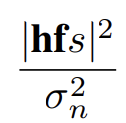

Where, h represents the channel/medium in which the beamed data would be travelling around and f representing a beamformeing vector from a pre-optimized beam steering codebook. These two are the only variables as the denominator is just the varaince of the variables. Moreover, as one can not always understand the channel in which data is being sent, especially when the channel is the everything surrounding the TX and RX as in the case of wireless communication, the variable to be optimzed is f. Therefore, the LSTM must predict an ideal beamforming vector for the data sent.

# Section 3 - Code

---



## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score,f1_score,roc_curve
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM
import re
from IPython.display import display
import os
import string
import time
import random
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
import io
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
import requests
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import scipy
import csv

random.seed(10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Acquiring the 6G dataset


In [ ]:
directory_path = '/content/drive/MyDrive/EECS 4214/Scenario8/Scenario8/development_dataset/'
file_path_test = directory_path + 'scenario8_dev_test.csv'
file_path_train = directory_path +  'scenario8_dev_train.csv'

def retrieve_dataset(file_path):
  with open(file_path, 'r') as file:
    # Read the first line to extract headers
    headers = file.readline().strip().split(',')

    # Read the remaining lines and store them in a list
    data_lines = file.readlines()

  # Convert the list of data lines into a DataFrame
  df = pd.DataFrame([line.strip().split(',') for line in data_lines], columns=headers)

  return df

df_test = retrieve_dataset(file_path_test)
df_train = retrieve_dataset(file_path_train)

print("********* Training Dataset *********")
df_train.info()
print("********* Testing Dataset *********")
df_test.info()

********* Training Dataset *********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2831 entries, 0 to 2830
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              2831 non-null   object
 1   unit1_lidar_1      2831 non-null   object
 2   unit1_lidar_SCR_1  2831 non-null   object
 3   unit1_pwr_1        2831 non-null   object
 4   beam_index_1       2831 non-null   object
dtypes: object(5)
memory usage: 110.7+ KB
********* Testing Dataset *********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              437 non-null    object
 1   unit1_lidar_1      437 non-null    object
 2   unit1_lidar_SCR_1  437 non-null    object
 3   unit1_pwr_1        437 non-null    object
 4   beam_index_1       437 non-null    object
dtypes: object(5)

In [ ]:


x_train = []
y_train = []

x_test = []
y_test = []
for i in range(len(df_train)):
  #concat the scr file path to root
  mat_directory = directory_path[:-1] + df_train.iloc[i,2][1:]
  #load all matlab variable data
  mat_data = scipy.io.loadmat(mat_directory)
  #extract the 'data' variable from the matlab data
  lidarData = mat_data['data'].transpose()
  #reshape the data to 1 sample, with 216 time steps and 2 features (distance and angle)
  lidarData = lidarData.reshape(2,216)
  x_train.append(lidarData)
  y_train.append(int(df_train.iloc[i,4]))


for i in range(len(df_test)):
  #concat the scr file path to root
  mat_directory = directory_path[:-1] + df_test.iloc[i,2][1:]
  #load all matlab variable data
  mat_data = scipy.io.loadmat(mat_directory)
  #extract the 'data' variable from the matlab data
  lidarData = mat_data['data'].transpose()
  #reshape the data to 1 sample, with 216 time steps and 2 features (distance and angle)
  lidarData = lidarData.reshape(2, 216)
  x_test.append(lidarData)
  y_test.append(int(df_test.iloc[i,4]))



x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)


In [ ]:
y_train = y_train.reshape(len(df_train), 1, 1)
y_test = y_test.reshape(len(df_test), 1, 1)
model = Sequential()
model.add(LSTM(128, activation= softplus, kernel_regularizer=regularizers.L2(0.01),
    bias_regularizer=regularizers.L2(0.01),
    activity_regularizer=regularizers.L2(0.01), input_shape = (2,216)))
model.add(Dense(10))
#model.add(Dropout(0.591))

def my_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

model.compile(optimizer= Nadam(), loss=LogCosh(), metrics = my_acc )

#epochs derived from article
history = model.fit(x_train, y_train, batch_size = 1 , epochs=300)

In [ ]:
def get_data_values(df):
  for idx, cell in enumerate(df):
      if isinstance(cell, str):
          if cell.startswith('.'):
              # Delete the first character (period) and concatenate with another string
              new_value = directory_path[:-1] + cell[1:]
              # Update the cell with the modified value
              df.at[idx] = new_value

  # load .mat files
  for idx, cell in enumerate(df):
      if isinstance(cell, str):  # Check if the cell contains a string
          # Load data from the .mat file and add it to the same cell
          df.at[idx] = load_data_from_mat(cell)
          # kernel_temp = pd.DataFrame(df.at[idx])
          # kernel_temp.info()

  return df

def load_data_from_mat(mat_file_path):
    mat_data = scipy.io.loadmat(mat_file_path)

    return mat_data['data']



df_train_CSR = get_data_values(df_train["unit1_lidar_SCR_1"])
# print(df_train_CSR)


# df_train_CSR = [{'distance': entry[0], 'angle': entry[1]} for entry in df_train_CSR]
# df_train_CSR = pd.DataFrame(df_train_CSR)

df_test_CSR = get_data_values(df_test["unit1_lidar_SCR_1"])
# df_test_CSR = [{'distance': entry[0], 'angle': entry[1]} for entry in df_test_CSR]
# df_test_CSR =  pd.DataFrame(df_test_CSR)


In [ ]:

# Convert the array of arrays into a numpy array
df_train_CSR = np.array(df_train_CSR)
print(df_train)
# Calculate the number of rows in the reshaped array
num_rows = -(-len(df_train_CSR)//216)

print(num_rows)

# Reshape the array to have 432 elements per row
reshaped_array = df_train_CSR.reshape(num_rows, 432)

# Create a DataFrame from the reshaped array
df_train_CSR = pd.DataFrame(reshaped_array)

print(df_train_CSR)

     index                            unit1_lidar_1  \
0        1  ./unit1/lidar_data/Lidar_data_27191.mat   
1        2   ./unit1/lidar_data/Lidar_data_4033.mat   
2        3  ./unit1/lidar_data/Lidar_data_10667.mat   
3        4  ./unit1/lidar_data/Lidar_data_22645.mat   
4        5  ./unit1/lidar_data/Lidar_data_11896.mat   
...    ...                                      ...   
2826  2827  ./unit1/lidar_data/Lidar_data_26231.mat   
2827  2828  ./unit1/lidar_data/Lidar_data_10668.mat   
2828  2829  ./unit1/lidar_data/Lidar_data_19252.mat   
2829  2830  ./unit1/lidar_data/Lidar_data_22630.mat   
2830  2831  ./unit1/lidar_data/Lidar_data_11569.mat   

                                      unit1_lidar_SCR_1  \
0     [[0.0, -2.094122394697571], [0.0, -2.072578486...   
1     [[0.0, -2.094395102393195], [0.0, -2.079396179...   
2     [[0.0, 0.0], [0.0, -2.0755782713951314], [0.0,...   
3     [[0.0, -2.0908499023500813], [0.0, -2.07148765...   
4     [[0.0, -2.0913953177413305], [0.0, -2.

ValueError: cannot reshape array of size 2831 into shape (14,432)

In [ ]:
# Sample dataset
dataset = df_train_CSR

# Convert the dataset to a numpy array
dataset_array = np.array(dataset)

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(len(df_train_CSR), 1)))
model.add(Dense(2))  # Assuming 2 output values per time step
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model for each row in the dataset
for row in dataset_array:
    X = row[:-1]  # Input data (all but the last element)
    y = row[1:]   # Target data (all but the first element)
    X = np.array(X).reshape(1, X.shape[1], X.shape[2])  # Reshape X for LSTM input
    y = np.array(y).reshape(1, y.shape[1], y.shape[2])  # Reshape y for LSTM input
    model.fit(X, y, epochs=100, verbose=0)  # Train the model for each row

# Make predictions (not shown in this example)


[[ 0.00000000e+00 -2.09412239e+00]
 [ 0.00000000e+00 -2.07257849e+00]
 [ 0.00000000e+00 -2.06030664e+00]
 [ 0.00000000e+00 -2.04612584e+00]
 [ 0.00000000e+00 -2.02730901e+00]
 [ 0.00000000e+00 -2.01231009e+00]
 [ 0.00000000e+00 -1.98558473e+00]
 [ 0.00000000e+00 -1.97113122e+00]
 [ 0.00000000e+00 -1.95176898e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.72214910e+00]
 [ 0.00000000e+00 -1.70687747e+00]
 [ 0.00000000e+00 -1.68042482e+00]
 [ 0.00000000e+00 -1.66597131e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0

NameError: name 'Y' is not defined

In [ ]:
df_train_CSR.head()

,distance,angle
0,"[0.0, -2.094122394697571]","[0.0, -2.072578486743266]"
1,"[0.0, -2.094395102393195]","[0.0, -2.0793961791338695]"
2,"[0.0, 0.0]","[0.0, -2.0755782713951314]"
3,"[0.0, -2.0908499023500813]","[0.0, -2.0714876559607696]"
4,"[0.0, -2.0913953177413305]","[0.0, -2.072578486743266]"


In [ ]:
df_train_CSR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2831 entries, 0 to 2830
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   distance  2831 non-null   object
 1   angle     2831 non-null   object
dtypes: object(2)
memory usage: 44.4+ KB


### Swapping .mat files for data


## Preprocessing Pipeline

In [ ]:
# Define a function for embedding layer
def embedding_layer(data, embedding_dim):
    reshaped_data = data.reshape(-1, embedding_dim)
    return reshaped_data

# Define the preprocessing pipeline (SRC is already given in the dataset)
preprocessing_pipeline = Pipeline([
    ('embedding', embedding_layer),       # Embedding Layer
    ('scaler', StandardScaler())          # StandardScaler
])

# Set embedding dimension
embedding_dim = 10

# Fit-transform the data using the preprocessing pipeline
processed_data = preprocessing_pipeline.fit_transform(time_series_data, embedding_dim=embedding_dim)

# 'processed_data' contains the pre-processed time series data ready to be used with an LSTM layer.